<h3> Import Packages </h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<h3> Import Data </h3>

In [2]:
def get_images(path):
    
    all_images_as_array=[]
    label=[]
    
    for filename in os.listdir(path):
        
        try:
            if re.match(r'bird',filename):
                label.append(1)
                
            else:
                label.append(0)
                
            img = Image.open(path+filename)
            np_array=np.asarray(img)
            all_images_as_array.append(np_array)
            
        except Exception as e:
            print(e)
            continue
            
    return np.array(all_images_as_array), np.array(label).reshape(1,-1)


# TODO Enter the URL for the folders here
train_set_x_orig, train_y = get_images("..//train_set//")
test_set_x_orig, test_y = get_images("..//test_set//")

In [3]:
#Create classes for your data
list_classes = ['non-bird','bird']
classes = np.array(list_classes) 

print ("Total of Birds in Training Set = " + str(np.unique(train_y, return_counts=True)[1][1]))
print ("Total of Non-Birds in Training Set = " + str(np.unique(train_y, return_counts=True)[1][0]))
print ("Total of Birds in Test Set = " + str(np.unique(test_y, return_counts=True)[1][1]))
print ("Total of Non-Birds in Test Set = " + str(np.unique(test_y, return_counts=True)[1][0]))


Total of Birds in Training Set = 380
Total of Non-Birds in Training Set = 78
Total of Birds in Test Set = 25
Total of Non-Birds in Test Set = 13


In [4]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_y.shape))

Number of training examples: m_train = 458
Number of testing examples: m_test = 38
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (458, 64, 64, 3)
train_set_y shape: (1, 458)
test_set_x shape: (38, 64, 64, 3)
test_set_y shape: (1, 38)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 458)
test_x's shape: (12288, 38)


<h3> 1. Initialize Parameters </h3>

In [7]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network


    for l in range(1, L):

        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        
    return parameters

<h3> 2. Forward Propagation </h3>

In [8]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    
    # number of layers in the neural network
    L = len(parameters) // 2

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):

        A_prev = A

        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]
        linear_cache = (A_prev,
                        parameters['W' + str(l)],
                        parameters['b' + str(l)])

        A = np.maximum(0, Z)

        cache = (linear_cache, Z)

        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    Z = np.dot(parameters['W' + str(L)], A) + parameters['b' + str(L)]

    linear_cache = (A,
                    parameters['W' + str(L)],
                    parameters['b' + str(L)])

    AL = 1/(1+np.exp(-Z))

    cache = (linear_cache, Z)

    caches.append(cache)

    assert(AL.shape == (1, X.shape[1]))

    return AL, caches

<h3> 3. Compute Cost </h3>

In [9]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = - np.sum(np.multiply(np.log(AL),Y) + np.multiply((1-Y),np.log(1-AL))) /m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

<h3> 4. Backward Propagation </h3>

In [10]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * (np.sum(dZ, axis=1, keepdims=True))
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [11]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.    
        dZ[activation_cache <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        s = 1/(1+np.exp(-cache[1]))
        dZ = dA * s * (1-s)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [12]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers

    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = linear_activation_backward(dAL,caches[L-1],"sigmoid")
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = current_cache
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = linear_activation_backward(grads["dA" + str(l + 1)],caches[l],"relu")
        dA_prev_temp, dW_temp, db_temp = current_cache
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

<h3> 5. Update Parameters </h3>

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)] 
    return parameters

<h3> Deep Neural Network </h3>

In [14]:
layers_dims = [12288, 5, 5, 5, 1] #  4-layer model

In [15]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.625081
Cost after iteration 200: 0.578084
Cost after iteration 300: 0.545295
Cost after iteration 400: 0.522115
Cost after iteration 500: 0.505503
Cost after iteration 600: 0.493440
Cost after iteration 700: 0.484573
Cost after iteration 800: 0.477984
Cost after iteration 900: 0.473040
Cost after iteration 1000: 0.469299
Cost after iteration 1100: 0.466446
Cost after iteration 1200: 0.464256
Cost after iteration 1300: 0.462565
Cost after iteration 1400: 0.461252
Cost after iteration 1500: 0.460229
Cost after iteration 1600: 0.459427
Cost after iteration 1700: 0.458798
Cost after iteration 1800: 0.458302
Cost after iteration 1900: 0.457910
Cost after iteration 2000: 0.457600
Cost after iteration 2100: 0.457353
Cost after iteration 2200: 0.457157
Cost after iteration 2300: 0.457001
Cost after iteration 2400: 0.456876


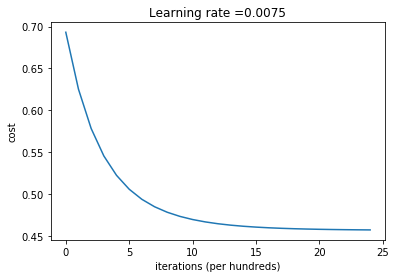

In [21]:
# This will take some minutes

parameters = L_layer_model(train_x, train_y, layers_dims, 
                           num_iterations = 2500, print_cost = True)

<h3> Predict </h3>

In [22]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [23]:
pred_train = predict(train_x, train_y, parameters) 

Accuracy: 0.8296943231441045


In [24]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.6578947368421052


<h3> Import your own image </h3>

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "bird" picture.


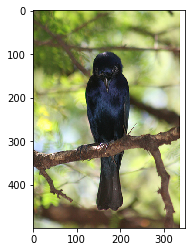

In [19]:
from scipy import ndimage

my_label_y = [1] 

# Pass the URL of an image here
img = Image.open("Shiny_Cowbird_0001_480522861.jpg")
new_img = img.resize((64, 64))
np_array = np.asarray(new_img)

my_image_flatten = np_array/255.
my_image = my_image_flatten.reshape(1, -1).T

my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(img)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" 
       + classes[int(np.squeeze(my_predicted_image)),] +  "\" picture.")